In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)


ModuleNotFoundError: No module named 'matplotlib'

ticker: AAPL
start: 2015-01-01
end: 2026-02-10
initial_capital: 1000000.000000
ending_value_strategy: 7550740.272120
ending_value_buyhold: 11302134.963843
profit_strategy: 6550740.272120
profit_pct_strategy: 6.550740
max_drawdown_strategy: -0.270335
trades: 199
fee_rate_per_trade: 0.000500


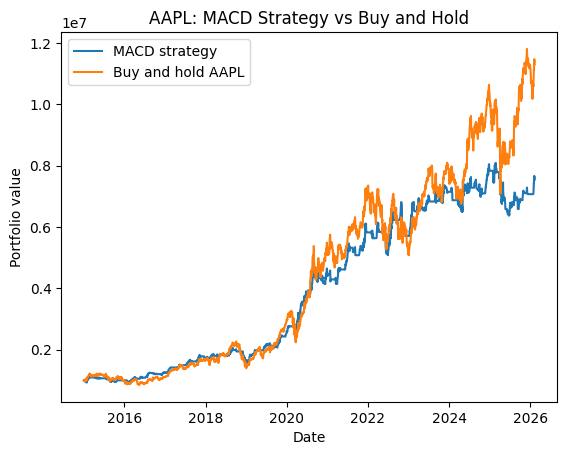

In [4]:


def backtest_macd(
    ticker: str = "AAPL",
    start: str = "2015-01-01",
    initial_capital: float = 1_000_000.0,
    fast_span: int = 12,
    slow_span: int = 26,
    signal_span: int = 9,
    fee_rate_per_trade: float = 0.0005
):
    data = yf.download(
        ticker,
        start=start,
        auto_adjust=True,
        progress=False
    )

    close = data["Close"]
    if isinstance(close, pd.DataFrame):
        close = close.iloc[:, 0]
    prices = close.dropna().astype(float)

    ema_fast = prices.ewm(span=fast_span, adjust=False).mean()
    ema_slow = prices.ewm(span=slow_span, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_span, adjust=False).mean()
    hist = macd - signal

    # Signal: long when MACD > Signal
    raw_position = (macd > signal).astype(int)
    # Shift by 1 day to avoid lookahead bias
    position = raw_position.shift(1).fillna(0).astype(int)

    returns = prices.pct_change().fillna(0.0)
    trades = position.diff().abs().fillna(0.0)  # 1 on entry/exit days

    strategy_returns_gross = position * returns
    strategy_returns_net = strategy_returns_gross - trades * fee_rate_per_trade

    equity_strategy = initial_capital * (1.0 + strategy_returns_net).cumprod()

    # Buy-and-hold benchmark (same initial capital)
    equity_buyhold = initial_capital * (prices / prices.iloc[0])

    final_value = float(equity_strategy.iloc[-1])
    profit = final_value - initial_capital
    profit_pct = final_value / initial_capital - 1.0

    running_max = equity_strategy.cummax()
    drawdown = equity_strategy / running_max - 1.0
    max_drawdown = float(drawdown.min())

    results = {
        "ticker": ticker,
        "start": start,
        "end": str(equity_strategy.index[-1].date()),
        "initial_capital": float(initial_capital),
        "ending_value_strategy": float(equity_strategy.iloc[-1]),
        "ending_value_buyhold": float(equity_buyhold.iloc[-1]),
        "profit_strategy": float(profit),
        "profit_pct_strategy": float(profit_pct),
        "max_drawdown_strategy": float(max_drawdown),
        "trades": int(trades.sum()),
        "fee_rate_per_trade": float(fee_rate_per_trade),
    }

    return prices, macd, signal, hist, position, equity_strategy, equity_buyhold, results


# ---- Run ----
prices, macd, signal, hist, position, equity_strategy, equity_buyhold, results = backtest_macd(
    ticker="AAPL",
    start="2015-01-01",
    initial_capital=1_000_000.0,
    fee_rate_per_trade=0.0005
)

for k, v in results.items():
    if isinstance(v, float):
        print(f"{k}: {v:.6f}")
    else:
        print(f"{k}: {v}")

# ---- Plot: strategy vs buy-and-hold ----
plt.figure()
plt.plot(equity_strategy, label="MACD strategy")
plt.plot(equity_buyhold, label="Buy and hold AAPL")
plt.title("AAPL: MACD Strategy vs Buy and Hold")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.legend()
plt.show()
